## Pipeline Script 
This script 

### Import Packages

In [255]:
import os
import glob
import numpy as np
import pandas as pd
import network_fcon as fc
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

### Define paths and variables

In [246]:
# Set paths
inpath = "/Users/pecsok/Desktop/Maggie/Graduate School/Project1_GluCEST_rsfMRI/xcp_output/xcp_d_test/" 
outpath = "~/Desktop/ImageData/PMACS_remote/analysis/postprocessing"
clinpath = "~/Desktop/ImageData/PMACS_remote/data/clinical"

# Choose what to analyse
networks = ["SalVentAttn", "VisCent"] 
CNB_scores = ["tap_tot", "er40_cr"]
CNB_valids = ["tap_valid", "er40_valid"] 
diag_scores = ["hstatus"] # ,"axis1_desc1","axis1_stat1"
demo_scores = ["sex", "age", "race","ethnic","dateDiff"]

# Make dataframe based on metrics of interest
#columns = ["BBLID"] + ["Session"] + networks
#fcon_df = pd.DataFrame(columns=columns)
#clin_df = pd.DataFrame(columns=["BBLID", "Session"] + CNB_scores + clinical_scores + diag_scores)
grp_df = pd.DataFrame(columns = ["BBLID"] + ["Session"] + demo_scores + networks + CNB_scores + diag_scores)
print(grp_df)

# Initialize empty lists and vars
bblids = []
sesids = []

# Import group dataframes and set indices
cnbmat = pd.read_csv(clinpath + "/cnb.csv", sep=',') 
diagmat = pd.read_csv(clinpath + "/diagnosis.csv", sep=',')
demomat = pd.read_csv(clinpath + "/demographics.csv", sep=',')
cnbmat.set_index('bblid', inplace = True)
diagmat.set_index('bblid', inplace = True)
demomat.set_index('bblid', inplace = True)

#### Troubleshooting: Initialize empty matrix for fcmats # FIX if desired:
num_matrices = 100  # You can change this to the desired number
matrix_shape = (700, 701)
index = pd.MultiIndex.from_product([range(num_matrices), range(matrix_shape[0]), range(matrix_shape[1])], names=['Matrix', 'Row', 'Column'])
fcmats = pd.DataFrame(data, index=index, columns=['Value'])

Empty DataFrame
Columns: [BBLID, Session, sex, age, race, ethnic, dateDiff, SalVentAttn, VisCent, tap_tot, er40_cr, hstatus]
Index: []


### Choose which modules to run

In [251]:
runfcon = False
runCNB = True
rundiag = True
rundemo = True
runCEST = True
run_grpanalysis = True

## Stage 1: Create Group Data Frame
### Import data, loop through subjects, and establish file paths

In [249]:
# Generates list of all file names
folder_names = [folder for folder in glob.glob(os.path.join(inpath, "*")) if os.path.isdir(folder)]

for subj_path in folder_names:
    # Extract bblid id:
    bblid = subj_path.split('-')[1]
    print("Processing subject " + bblid)
    # Extract session id: 
    items = os.listdir(subj_path)
    ses_folder = [item for item in items if item.startswith("ses")]
    ses = ses_folder[0].split('-')[1]
    ses_path = os.path.join(inpath, subj_path, ses_folder[0]) # full path to session
    # Add to running list of IDs grp analysis later:
    bblids.append(bblid)
    sesids.append(ses)
    # Start new row in grp_df for this subject:
    ids = [bblid, ses]  # Values for the first two columns
    grp_df.loc[len(grp_df)] = ids + [float('nan')] * (len(grp_df.columns) - len(ids))
    
    ##################################################################################################
    ## FC
    ##################################################################################################
    if runfcon:
    #    fc.subj_fcon(ses_path, bblid, ses, grp_df, networks) Troubleshoot function
        fcmat_glob = f"{ses_path}/func/*Schaefer717_measure-pearsoncorrelation_conmat.tsv"
        fcmat = pd.read_csv(glob.glob(fcmat_glob)[0], sep='\t') # read in fcmat
        fcmat.set_index('Node', inplace = True)
        # Loop through the networks
        for network in networks:
            # Select rows and columns corresponding to the network
            network_fc = fcmat.loc[fcmat.index.str.contains(network), fcmat.columns[fcmat.columns.str.contains(network)]]
            # Calculate avg network fc and add value to proper column in grp_df
            grp_df.loc[len(grp_df)-1, network] = network_fc.values.mean()

    ##################################################################################################
    ## CNB
    ##################################################################################################
    if runCNB:
        # Loop through the CNB scores
        for i in range(len(CNB_scores)):
            CNB_score = CNB_scores[i]
            CNB_valid = CNB_valids[i]
            # Select score of interest & validity of that score
            scores = cnbmat[CNB_score]
            score = scores[int(bblid)]
            valids = cnbmat[CNB_valid]
            valid = str(valids[int(bblid)])
            # If score was valid, add to grp_df
            if 'V' in valid: 
                print(bblid + "'s " + CNB_score + " is valid.")
                grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == CNB_score] = score 
 
    ##################################################################################################
    ## Diagnosis
    ##################################################################################################
    if rundiag:
        # Loop through the CNB scores
        for i in range(len(diag_scores)):
            diag_score = diag_scores[i]
            # Select score of interest and add to grp_df
            diagnoses = diagmat[diag_score]
            diagnosis = diagnoses[int(bblid)]
            grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == diag_score] = diagnosis 

    ##################################################################################################
    ## Demographics
    ##################################################################################################
    if rundemo:
        # Loop through the CNB scores
        for i in range(len(demo_scores)):
            demo_score = demo_scores[i]
            # Select metric of interest
            scores = demomat[demo_score]
            score = scores[int(bblid)]
            # Add to grp_df
            grp_df.loc[grp_df['BBLID'] == bblid, grp_df.columns == demo_score] = score 
            
    ##################################################################################################
    ## CEST
    ##################################################################################################
    if runcest:
    #    fc.subj_fcon(ses_path, bblid, ses, grp_df, networks) Troubleshoot function
        fcmat_glob = f"{ses_path}/func/*Schaefer717_measure-pearsoncorrelation_conmat.tsv"
        fcmat = pd.read_csv(glob.glob(fcmat_glob)[0], sep='\t') # read in fcmat
        fcmat.set_index('Node', inplace = True)
        # Loop through the networks
        for network in networks:
            # Select rows and columns corresponding to the network
            network_fc = fcmat.loc[fcmat.index.str.contains(network), fcmat.columns[fcmat.columns.str.contains(network)]]
            # Calculate avg network fc and add value to proper column in grp_df
            grp_df.loc[len(grp_df)-1, network] = network_fc.values.mean()

            

Processing subject 18199
Processing subject 116019
116019's tap_tot is valid.
116019's er40_cr is valid.


## Stage 2: Group Comparisons and Regressions

/Users/pecsok/anaconda3/envs/glucestfmri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


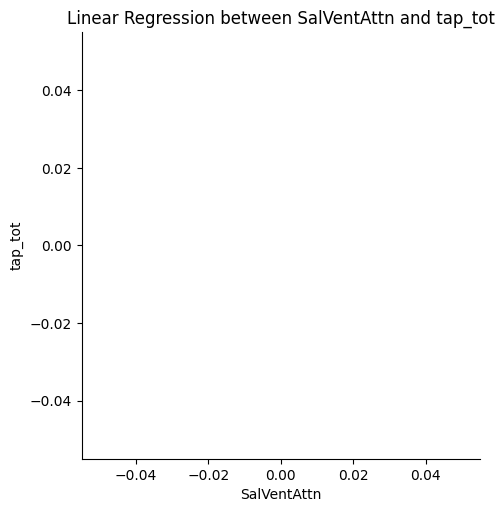

/Users/pecsok/anaconda3/envs/glucestfmri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


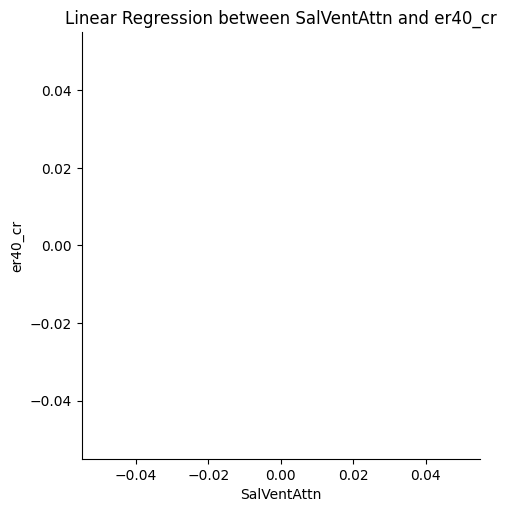

/Users/pecsok/anaconda3/envs/glucestfmri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


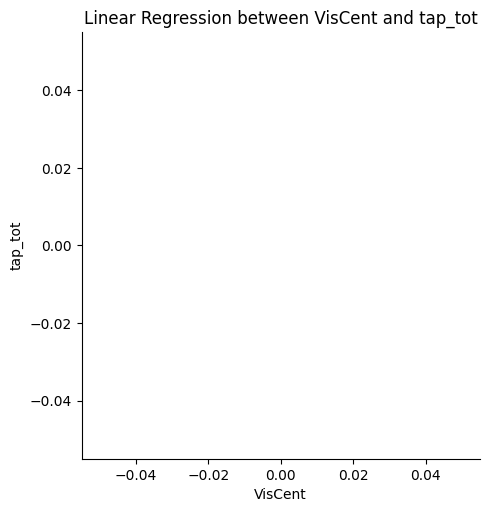

/Users/pecsok/anaconda3/envs/glucestfmri/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


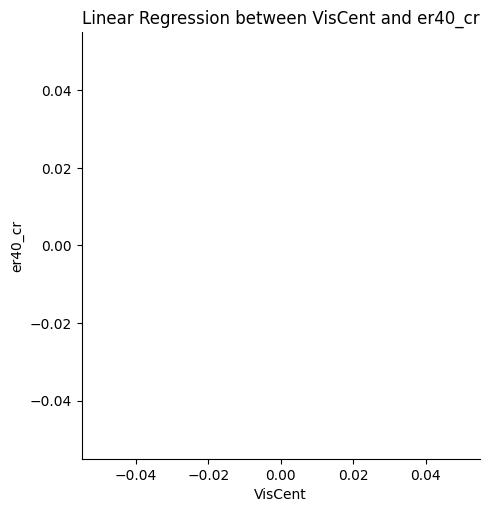

In [257]:
if run_grpanalysis:
    # Create a scatter plot with a linear regression line
    for network in networks:
        for CNB_score in CNB_scores:
            sns.lmplot(x=network, y='tap_tot', data=grp_df)
            # Add labels and a title to the plot
            plt.xlabel(network)
            plt.ylabel(CNB_score)
            plt.title('Linear Regression between ' + network + ' and ' + CNB_score)
            # Show the plot
            plt.show()

### Network FCON 
Call fcon function and calculate network-level connectivity measures for subject and add  subject data to group file for future group analysis